In [1]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score,  StratifiedShuffleSplit,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from joblib import Parallel, delayed

# Preprocessing 

##### Data exploration : getting info from the data, dropping unusefull features

In [2]:
# Data reading
data = pd.read_csv('/Users/imanehaddouchi/Documents/M1MIA/HoML/water-potability/Water Quality Prediction.csv')

# Data info
print("Informations sur les données :")
data.info()
print("\nNombre de valeurs uniques par colonne :")
print(data.nunique())
# Distribution des classes cibles
print("\nRépartition des classes cibles :\n", data['Target'].value_counts())

# Unusefull feature dropping
features_to_drop = ['Index','Month','Day','Time of Day']
data.drop(columns=features_to_drop, inplace=True)

data.head()

Informations sur les données :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 24 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Index                   1048575 non-null  int64  
 1   pH                      1028344 non-null  float64
 2   Iron                    1041584 non-null  float64
 3   Nitrate                 1029880 non-null  float64
 4   Chloride                1017741 non-null  float64
 5   Lead                    1043891 non-null  float64
 6   Zinc                    1020900 non-null  float64
 7   Color                   1047594 non-null  object 
 8   Turbidity               1039881 non-null  float64
 9   Fluoride                1015357 non-null  float64
 10  Copper                  1013693 non-null  float64
 11  Odor                    1017243 non-null  float64
 12  Sulfate                 1014050 non-null  float64
 13  Conductivity            10

,pH,Iron,Nitrate,Chloride,Lead,Zinc,Color,Turbidity,Fluoride,Copper,Odor,Sulfate,Conductivity,Chlorine,Manganese,Total Dissolved Solids,Source,Water Temperature,Air Temperature,Target
0,8.332988,0.000083,8.605777,122.799772,3.710000e-52,3.434827,Colorless,0.022683,0.607283,0.144599,1.626212,87.266538,471.683357,3.708178,2.270000e-15,332.118789,NaN,NaN,43.493324,0
1,6.917863,0.000081,3.734167,227.029851,7.850000e-94,1.245317,Faint Yellow,0.019007,0.622874,0.437835,1.686049,144.010981,432.844908,3.292038,8.020000e-07,284.641984,Lake,15.348981,71.220586,0
2,5.443762,0.020106,3.816994,230.995630,5.290000e-76,0.528280,Light Yellow,0.319956,0.423423,0.431588,3.414619,275.702107,990.201209,3.560224,7.007989e-02,570.054094,River,11.643467,44.891330,0
3,7.955339,0.143988,8.224944,178.129940,4.000000e-176,4.027879,Near Colorless,0.166319,0.208454,0.239451,NaN,147.163233,237.028468,3.516907,2.468295e-02,100.043838,Ground,10.092392,60.843233,0
4,8.091909,0.002167,9.925788,186.540872,4.170000e-132,3.807511,Light Yellow,0.004867,0.222912,0.616574,0.795310,175.275175,385.025855,3.177849,3.296139e-03,168.075545,Spring,15.249416,69.336671,0


#### NaN values location visualization 

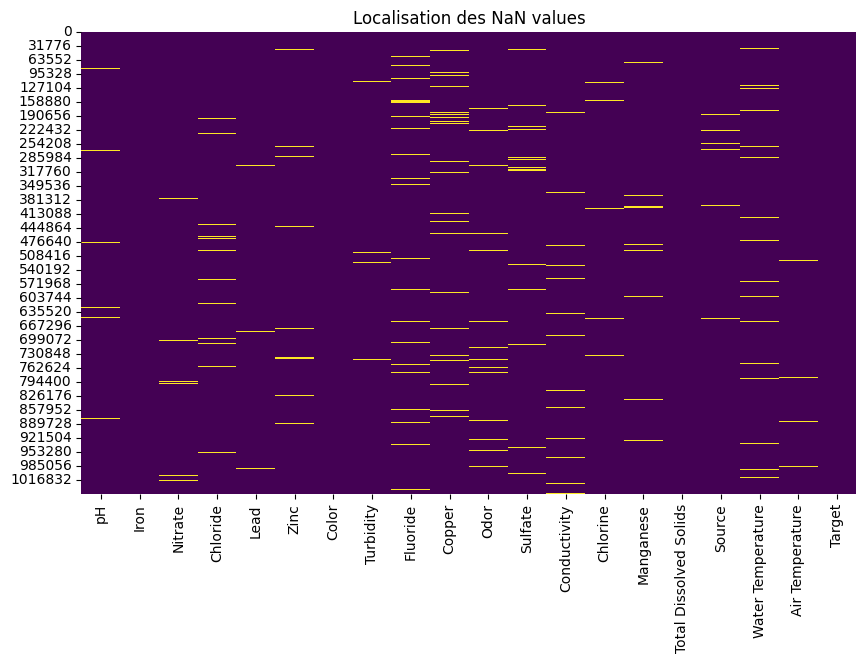

In [3]:
plt.figure(figsize=(10, 6))
sns.heatmap(data.isna(), cbar=False, cmap="viridis")
plt.title("Localisation des NaN values")
plt.show()

#### NaN values 

In [4]:
# Calcul du pourcentage de NaN
nan_percentage = data.isna().mean() * 100
print("\nPourcentage de valeurs manquantes avant traitement :\n", nan_percentage)

# Suppression des colonnes avec plus de 50% de NaN
data.drop(columns=nan_percentage[nan_percentage > 50].index, inplace=True)

# Identification des colonnes numériques et catégorielles
num_cols = data.select_dtypes(include=['float64', 'int64']).columns
cat_cols = data.select_dtypes(include=['object']).columns

# Imputation des valeurs manquantes
num_imputer = SimpleImputer(strategy='mean')  # Imputation par la moyenne
cat_imputer = SimpleImputer(strategy='most_frequent')  # Mode pour les catégorielles

data[num_cols] = num_imputer.fit_transform(data[num_cols])
data[cat_cols] = cat_imputer.fit_transform(data[cat_cols])

# Vérification des NaN après imputation
print("\nValeurs manquantes après traitement :\n", data.isna().sum())


Pourcentage de valeurs manquantes avant traitement :
 pH                        1.929380
Iron                      0.666714
Nitrate                   1.782896
Chloride                  2.940562
Lead                      0.446701
Zinc                      2.639296
Color                     0.093556
Turbidity                 0.829125
Fluoride                  3.167918
Copper                    3.326610
Odor                      2.988055
Sulfate                   3.292564
Conductivity              2.746871
Chlorine                  0.969125
Manganese                 1.844313
Total Dissolved Solids    0.028420
Source                    1.481534
Water Temperature         2.831271
Air Temperature           0.505734
Target                    0.000000
dtype: float64

Valeurs manquantes après traitement :
 pH                        0
Iron                      0
Nitrate                   0
Chloride                  0
Lead                      0
Zinc                      0
Color                 

In [5]:
# Encodage des colonnes catégorielles
df_cat = data.select_dtypes(include=['object']).copy()
cat_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
df_cat_encoded = cat_encoder.fit_transform(df_cat)
df_cat_encoded = pd.DataFrame(df_cat_encoded, columns=cat_encoder.get_feature_names_out(df_cat.columns))

df_cat_encoded.index = data.index
data = pd.concat([data.drop(cat_cols, axis=1), df_cat_encoded], axis=1)

# Mettre à jour cat_cols pour refléter les nouvelles colonnes encodées
cat_cols_encoded = df_cat_encoded.columns

# Visualisation des colonnes catégorielles avant et après encodage
print("\nColonnes catégorielles avant encodage :\n", df_cat.head())
print("\nColonnes catégorielles après encodage :\n", df_cat_encoded.head())

# Statistiques descriptives
print("\nStatistiques descriptives des données numériques :\n", data.describe())

# Utiliser les nouvelles colonnes catégorielles encodées
print("\nNombre de catégories par variable catégorielle :\n", data[cat_cols_encoded].nunique())



Colonnes catégorielles avant encodage :
             Color  Source
0       Colorless    Well
1    Faint Yellow    Lake
2    Light Yellow   River
3  Near Colorless  Ground
4    Light Yellow  Spring

Colonnes catégorielles après encodage :
    Color_Colorless  Color_Faint Yellow  Color_Light Yellow  \
0              1.0                 0.0                 0.0   
1              0.0                 1.0                 0.0   
2              0.0                 0.0                 1.0   
3              0.0                 0.0                 0.0   
4              0.0                 0.0                 1.0   

   Color_Near Colorless  Color_Yellow  Source_Aquifer  Source_Ground  \
0                   0.0           0.0             0.0            0.0   
1                   0.0           0.0             0.0            0.0   
2                   0.0           0.0             0.0            0.0   
3                   1.0           0.0             0.0            1.0   
4                   0.0    

### Data scaling using minmax method

In [6]:
#mise à l'échelle des données

scaler = MinMaxScaler(feature_range=(0, 1))
data = pd.DataFrame(scaler.fit_transform(data), columns = data.columns)
data.describe().loc[['min', 'mean', 'std', 'max']].T.style.background_gradient(axis=1)


,min,mean,std,max
pH,0.000000,0.497682,0.077500,1.000000
Iron,0.000000,0.007236,0.028056,1.000000
Nitrate,0.000000,0.079581,0.042643,1.000000
Chloride,0.000000,0.108806,0.046243,1.000000
Lead,0.000000,0.000369,0.008628,1.000000
Zinc,0.000000,0.053895,0.052362,1.000000
Turbidity,0.000000,0.025062,0.044459,1.000000
Fluoride,0.000000,0.073221,0.060680,1.000000
Copper,0.000000,0.043364,0.048878,1.000000
Odor,0.000000,0.426481,0.250664,1.000000


#### Rate of potable and non potable water in our dataset


Répartition de la variable cible :
Target
0.0    807841
1.0    240734
Name: count, dtype: int64


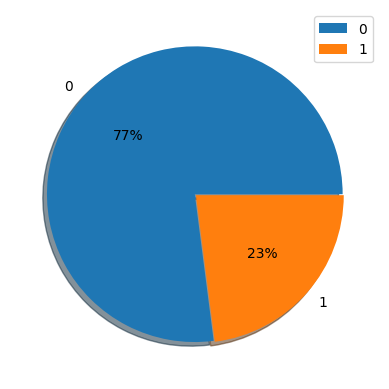

In [7]:
# Visualisation de la distribution de la variable cible
tar = data['Target'].value_counts()
print("\nRépartition de la variable cible :")
print(tar)

plt.pie(tar, labels=[0, 1], explode=[0, 0.01], autopct='%.f%%', shadow=True)
plt.legend()
plt.show()

# Training 

PCA

In [11]:
X = data.drop('Target', axis=1)
y_target = data['Target']

pca = PCA()
NB = GaussianNB()
SCORINGS = "accuracy"

pipe = Pipeline(
    steps=[
		("pca", pca),
		("NB", NB),
	]
)

param_grid =  {"pca__n_components": [20,25,27,30]}

search = GridSearchCV(pipe, param_grid, n_jobs = -1, scoring= SCORINGS, verbose = 1, cv=5)

search.fit(X, y_target)

#Print the best prediction score obtained, it correspond to the hyperparameter value

print(f"Best parameter (f1-score: {search.best_score_: .3f})")

print(search.best_params_)

cv_results_df = pd.DataFrame(search.cv_results_)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameter (f1-score:  0.828)
{'pca__n_components': 25}


In [12]:
# Appliquer la PCA avec n_components = 25
n_components = 25
pca = PCA(n_components=n_components)

# Transformation des données
X_pca = pca.fit_transform(X)

# Convertir les résultats PCA en DataFrame
X_pca_df = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(n_components)])

# Affichage des 5 premières lignes des données transformées
print("\nLes 5 premières lignes des données après PCA :")
print(X_pca_df.head())


Les 5 premières lignes des données après PCA :
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.708514 -0.335861 -0.110724  0.916975  0.000434 -0.003639 -0.007386   
1 -0.003361  0.847721 -0.398902 -0.150084 -0.016817  0.051350  0.235360   
2 -0.000932  0.356242  0.948826 -0.124252 -0.005033  0.084953  0.574823   
3 -0.706316 -0.344883 -0.111217 -0.155050 -0.081627  0.722228 -0.549000   
4 -0.003733  0.315029  0.893282 -0.121272  0.004426  0.047971  0.188743   

        PC8       PC9      PC10  ...      PC16      PC17      PC18      PC19  \
0  0.003358  0.000155  0.001621  ...  0.077850  0.052191 -0.032431  0.050472   
1 -0.457006  0.763539 -0.085732  ... -0.047189 -0.004152 -0.030495 -0.009254   
2  0.718959  0.061094 -0.024124  ... -0.181433 -0.003590 -0.061635 -0.029247   
3  0.161638  0.022153 -0.008045  ...  0.043429  0.034183 -0.046447  0.089725   
4 -0.318212 -0.343094  0.752544  ...  0.061434 -0.007880 -0.045176  0.088238   

       PC20      PC2

### Train different models

In [24]:
#X_selected = X
X_selected = X_pca_df
y_target = data['Target']
x_train, x_test, y_train, y_test = train_test_split(X_selected, y_target, test_size=0.2, random_state=42)


### Training sans cross val 

In [21]:
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd

# Initialisation des modèles
models = {
    'Logistic Regression': LogisticRegression(solver='liblinear'),
    'Gaussian NB': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

# Fonction pour entraîner et évaluer un modèle
def train_and_evaluate_model(name, model, x_train, y_train, x_test, y_test):
    """Entraîne un modèle, effectue des prédictions et calcule les métriques."""
    print(f"Processing {name}...")
    
    # Entraînement du modèle
    model.fit(x_train, y_train)
    
    # Prédictions et probabilités
    y_pred = model.predict(x_test)
    y_probs = model.predict_proba(x_test)[:, 1]  # Probabilités pour la classe 1
    
    # Calcul des métriques
    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_probs),
        'F1 Score': f1_score(y_test, y_pred),
        'Confusion Matrix': confusion_matrix(y_test, y_pred)  # Ajouter la matrice pour un affichage ultérieur
    }
    
    return metrics

# Fonction pour entraîner tous les modèles en parallèle
def parallel_training(models, x_train, y_train, x_test, y_test):
    """Entraîne tous les modèles en parallèle et retourne les résultats dans un DataFrame."""
    results = Parallel(n_jobs=-1)(
        delayed(train_and_evaluate_model)(name, model, x_train, y_train, x_test, y_test)
        for name, model in models.items()
    )
    # Convertir les résultats en DataFrame pour une analyse facile
    return pd.DataFrame(results).sort_values(by="AUC", ascending=False)

# Fonction pour afficher une matrice de confusion (avec sauvegarde dans un fichier)
def plot_confusion_matrix(cm, model_name):
    """Génère et sauvegarde une matrice de confusion."""
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=['Non potable', 'Potable'], 
                yticklabels=['Non potable', 'Potable'])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel('Predictions')
    plt.ylabel('Real')
    plt.savefig(f"confusion_matrix_{model_name}.png")
    plt.close()  # Ferme la figure pour économiser la mémoire

# Fonction pour afficher toutes les matrices de confusion en parallèle
def plot_all_confusion_matrices_parallel(results_df):
    """Affiche toutes les matrices de confusion en parallèle."""
    Parallel(n_jobs=-1)(
        delayed(plot_confusion_matrix)(row['Confusion Matrix'], row['Model'])
        for _, row in results_df.iterrows()
    )

# Appel principal (remplacez x_train, y_train, x_test, y_test par vos données)
results_df = parallel_training(models, x_train, y_train, x_test, y_test)

# Affichage des résultats triés par AUC
print("Résultats sans CV :\n", results_df)

# Affichage de toutes les matrices de confusion en parallèle
plot_all_confusion_matrices_parallel(results_df)

Processing Gaussian NB...
Processing Logistic Regression...
Processing K-Nearest Neighbors...
Processing Decision Tree...
Processing Random Forest...
Résultats sans CV :
                  Model  Accuracy       AUC  F1 Score  \
3        Random Forest  0.863853  0.911284  0.743869   
1          Gaussian NB  0.828195  0.874924  0.622541   
0  Logistic Regression  0.806504  0.836915  0.462109   
4  K-Nearest Neighbors  0.811635  0.811083  0.497705   
2        Decision Tree  0.819808  0.745677  0.607807   

                    Confusion Matrix  
3   [[139702, 21908], [6644, 41461]]  
1  [[143973, 17637], [18393, 29712]]  
0   [[151705, 9905], [30674, 17431]]  
4  [[150641, 10969], [28534, 19571]]  
2  [[142644, 18966], [18823, 29282]]  


### training avec cross val

In [28]:

#CROSS VALLLLLLLLLLLL

from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold
import pandas as pd
from sklearn.datasets import make_classification

# Génération des données factices
X, y = make_classification(
    n_samples=1000, n_features=20, n_informative=15, 
    n_redundant=5, random_state=42
)

# Initialisation des modèles
models = {
    'Logistic Regression': LogisticRegression(solver='liblinear'),
    'Gaussian NB': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

# Fonction pour entraîner et évaluer un modèle avec validation croisée
def train_and_evaluate_model_cv(name, model, X, y, cv):
    """Effectue une validation croisée, calcule les métriques et retourne les résultats."""
    print(f"Processing {name}...")
    
    # Obtenir les prédictions en validation croisée
    y_pred = cross_val_predict(model, X, y, cv=cv, n_jobs=-1)
    y_probs = cross_val_predict(model, X, y, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
    
    # Calcul des métriques
    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y, y_pred),
        'AUC': roc_auc_score(y, y_probs),
        'F1 Score': f1_score(y, y_pred),
        'Confusion Matrix': confusion_matrix(y, y_pred)
    }
    
    return metrics

# Fonction pour entraîner tous les modèles en parallèle avec validation croisée
def parallel_training_cv(models, X, y, cv):
    """Entraîne tous les modèles avec validation croisée en parallèle et retourne les résultats dans un DataFrame."""
    results = Parallel(n_jobs=-1)(
        delayed(train_and_evaluate_model_cv)(name, model, X, y, cv)
        for name, model in models.items()
    )
    return pd.DataFrame(results).sort_values(by="AUC", ascending=False)

# Fonction pour afficher une matrice de confusion (avec sauvegarde dans un fichier)
def plot_confusion_matrix(cm, model_name):
    """Génère et sauvegarde une matrice de confusion."""
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=['Non potable', 'Potable'], 
                yticklabels=['Non potable', 'Potable'])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel('Predictions')
    plt.ylabel('Real')
    plt.savefig(f"confusion_matrix_{model_name}.png")
    plt.close()

# Fonction pour afficher toutes les matrices de confusion en parallèle
def plot_all_confusion_matrices_parallel(results_df):
    """Affiche toutes les matrices de confusion en parallèle."""
    Parallel(n_jobs=-1)(
        delayed(plot_confusion_matrix)(row['Confusion Matrix'], row['Model'])
        for _, row in results_df.iterrows()
    )

# Configuration de la validation croisée
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Entraîner les modèles avec validation croisée
results_df = parallel_training_cv(models, X, y, cv)

# Affichage des résultats triés par AUC
print("Résultats avec validation croisée :\n", results_df)

# Affichage de toutes les matrices de confusion en parallèle
plot_all_confusion_matrices_parallel(results_df)


Processing Gaussian NB...
Processing Logistic Regression...
Processing K-Nearest Neighbors...
Processing Decision Tree...
Processing Random Forest...
Résultats avec validation croisée :
                  Model  Accuracy       AUC  F1 Score          Confusion Matrix
4  K-Nearest Neighbors     0.921  0.970888  0.921705    [[456, 46], [33, 465]]
3        Random Forest     0.913  0.970722  0.912387    [[460, 42], [45, 453]]
0  Logistic Regression     0.812  0.895882  0.810484    [[410, 92], [96, 402]]
1          Gaussian NB     0.790  0.875878  0.779874   [[418, 84], [126, 372]]
2        Decision Tree     0.780  0.762928  0.774590  [[402, 100], [120, 378]]


### Affichage des réusultats

In [ ]:
### Résusltats obtenus par le training sans cross val

results_sanscv = {'Logistic Regression': {'Accuracy': 0.8065040650406504, 'AUC': 0.8369147989927078, 'F1 Score': 0.46210946302408507}, 
                  'Gaussian NB': {'Accuracy': 0.8281954080537873, 'AUC': 0.8749236719525983, 'F1 Score': 0.6225407002325728}, 
                  'Decision Tree': {'Accuracy': 0.8192690079393462, 'AUC': 0.7448745461145214, 'F1 Score': 0.6065890265927633}, 
                  'Random Forest': {'Accuracy': 0.8643158572348186, 'AUC': 0.9117283274453369, 'F1 Score': 0.7448371100370347}, 
                  'K-Nearest Neighbors': {'Accuracy': 0.8116348377560022, 'AUC': 0.8110827447057409, 'F1 Score': 0.4977048763430606}}

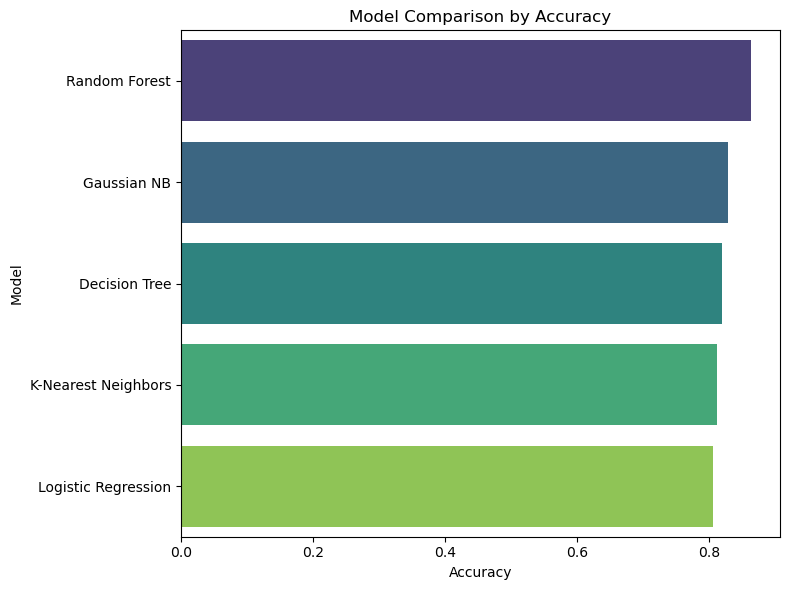

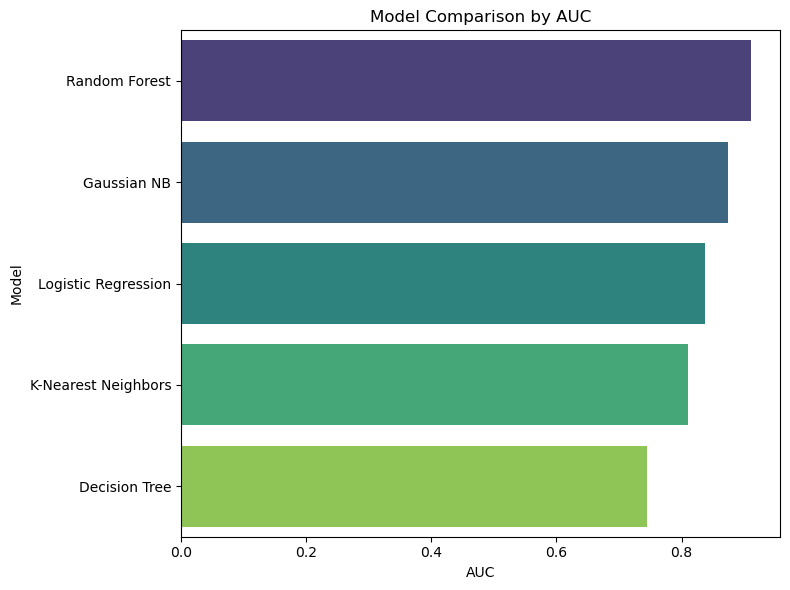

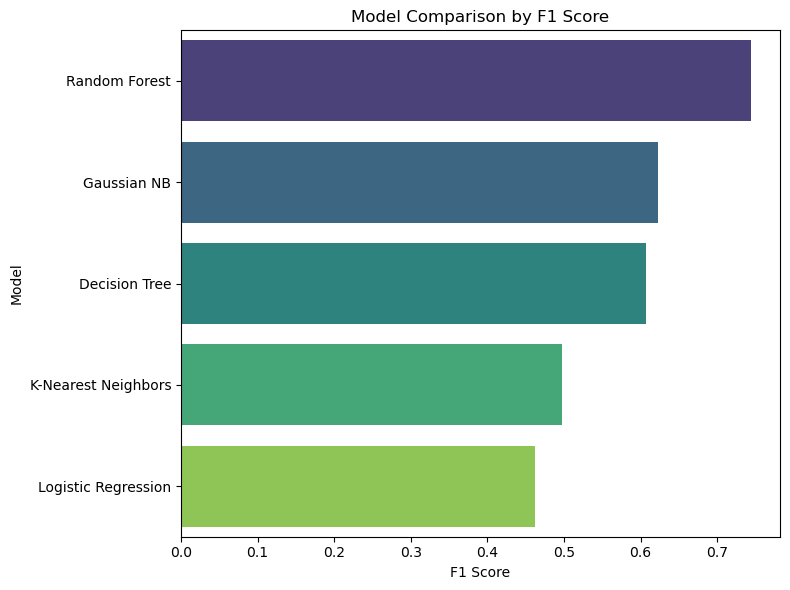

In [ ]:
results_df = pd.DataFrame(results_sanscv).T.reset_index().rename(columns={
    'index': 'Model',
    'CV Accuracy': 'Accuracy',
    'CV AUC': 'AUC',
    'CV F1 Score': 'F1 Score'
})

for metric in ['Accuracy', 'AUC', 'F1 Score']:
    # Tri des modèles par la métrique courante
    sorted_results = results_df.sort_values(by=metric, ascending=False)
    
    # Création du barplot
    plt.figure(figsize=(8, 6))
    sns.barplot(
        x=metric, 
        y='Model', 
        data=sorted_results, 
        hue='Model',  # Assigner la variable 'Model' à hue
        dodge=False,  # Évite tout décalage horizontal
        palette="viridis",
        legend=False  # Désactive la légende
    )
    plt.title(f'Model Comparison by {metric}')
    plt.xlabel(metric)
    plt.ylabel('Model')
    plt.tight_layout()
    plt.show()
